# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |



In [3]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol



def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}



ema_logging.log_to_stderr(ema_logging.INFO)


uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)
                ] 


outcomes = [TimeSeriesOutcome('TIME'),
            TimeSeriesOutcome('predators'),
            TimeSeriesOutcome('prey')]


py_model = Model('Python', function=PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using the statsmodel library and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment


In [16]:
n_exp = 1000

results_lhs = perform_experiments(py_model, scenarios=n_exp,
                                  uncertainty_sampling=LHS)

exp_lhs, out_lhs = results_lhs

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [5]:
out_lhs['predators'].shape

(1000, 1, 1461)

For each of the sampling methods, we can then select outcomes of interest: the final values of the prey variable, the mean of the prey variable over time within each experiment, and the standard deviation of the same variable across time (again in each experiment).

In [6]:
prey_final_lhs = out_lhs['prey'][:,0,-1]
prey_final_lhs.shape

(1000,)

In [7]:
prey_final_lhs = out_lhs['prey'][:,0,-1]
prey_mean_lhs = np.mean(out_lhs['prey'][:,0,:],axis=1)
prey_std_lhs = np.std(out_lhs['prey'][:,0,:],axis=1)

As an example, we can first fit a linear regression model to the prey_final_lhs outcome. We first drop the 'model' and 'policy' columns from the experiments, which were not used in this example. The add_constant method can be used to add an intercept to the regression model.

In [8]:
import statsmodels.api as sm

X = pd.DataFrame(exp_lhs).drop(['model','policy'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(prey_final_lhs, X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     126.6
Date:                Mon, 20 May 2019   Prob (F-statistic):          8.81e-104
Time:                        10:37:27   Log-Likelihood:                -4183.6
No. Observations:                1000   AIC:                             8379.
Df Residuals:                     994   BIC:                             8409.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  32.9559    

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Sobol

In this case, the linear regression clearly isn't capturing most of the output variance (as shown by the R2 value). We can therefore use the Sobol results with the SALib analysis functions for a more comprehensive analysis. We first use the get_SALib_problem to convert the uncertainties we have previously defined, to a dictionary which is compatible with SALib. This includes the names and bounds of the uncertainties.



* Perform an appropriate number of experiments with the Sobol sampling functionality included in the Workbench, then analyze the results with SALib for the same three indicators. How can we interpret the first-order and total indices? Does your chosen sample size give a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

Note that the Sobol analysis will require N(2k+2) samples, where N is a baseline number of experiments required to cover the uncertainties (let's also assume 1000 in this case) and k is the number of uncertainties. We have k = 4 uncertainties, so we'll have 1000 * (8 + 2) = 10,000 experiments in total. We can choose the sampling by specifying the uncertainty_sampling argument; note that the Sobol sampler automatically adjusts the number of experiments based on the number of uncertainties and the specified value of N.

In [9]:
problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 4, 'names': ['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate'], 'bounds': [(0.0005, 0.003), (0.001, 0.004), (0.04, 0.08), (0.015, 0.035)]}


We can then pass the problem and the outcome values (using the results with the Sobol sample, instead of the LHS sample) to the SALib analysis function. By default, the Sobol sampler calculates second-order interaction effects between each pair of variables.

In [11]:
n_exp = 1000

experiments_sobol, outcomes_sobol = perform_experiments(py_model, scenarios=n_exp,
                                                        uncertainty_sampling=SOBOL)

prey_final_sobol = outcomes_sobol['prey'][:,0,-1]
prey_mean_sobol = np.mean(outcomes_sobol['prey'][:,0,:],axis=1)
prey_std_sobol = np.std(outcomes_sobol['prey'][:,0,:],axis=1)

Si = sobol.analyze(problem, prey_mean_sobol, calc_second_order=True, print_to_console=True)

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


Parameter S1 S1_conf ST ST_conf
predation_rate 0.001691 0.006509 0.005197 0.000990
predator_efficiency 0.769440 0.086203 0.817172 0.071059
predator_loss_rate 0.179886 0.041957 0.218995 0.025026
prey_birth_rate 0.002274 0.009368 0.011610 0.001362

Parameter_1 Parameter_2 S2 S2_conf
predation_rate predator_efficiency -0.001912 0.014504
predation_rate predator_loss_rate 0.003159 0.009469
predation_rate prey_birth_rate 0.000748 0.009346
predator_efficiency predator_loss_rate 0.058777 0.146677
predator_efficiency prey_birth_rate 0.008593 0.126829
predator_loss_rate prey_birth_rate -0.007227 0.060187


The SALib analysis returns a dictionary with keys for the different relevant indicators (e.g. S1 and ST for first-order and total effects). The values are in the same order as the names of the problem dictionary, and indicate the fraction of total output variance corresponding to each of the indices (so that, for example, the predator_efficiency variable contributes approximately 40% of variance on its own, or over 80% when including interactions with other inputs). We can quickly visualize the first-order and total effects as well as their confidence intervals, by converting the results to a DataFrame:

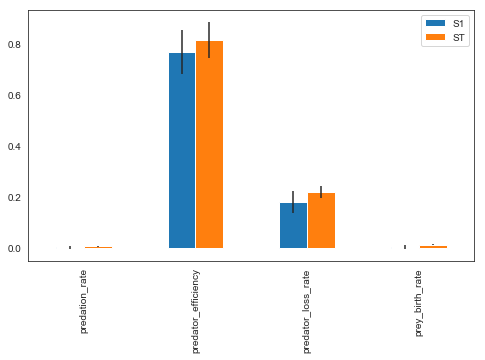

In [12]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

We can also study the convergence of the Sobol indices as a function of the number of samples, by computing the indices over a partial sample:

In [13]:
Y = prey_mean_sobol

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

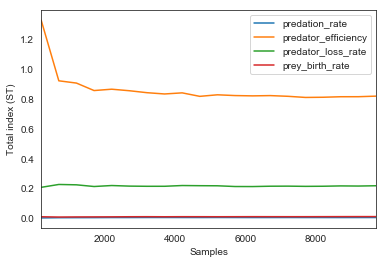

In [14]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()

## Extra trees

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices?

In [17]:
from ema_workbench.analysis import feature_scoring

In [ ]:
prey_final_sobol = outcomes_sobol['prey'][:,0,-1]
prey_mean_sobol = np.mean(outcomes_sobol['prey'][:,0,:],axis=1)
prey_std_sobol = np.std(outcomes_sobol['prey'][:,0,:],axis=1)

In [22]:
scores = feature_scoring.get_ex_feature_scores(experiments_sobol, prey_final_sobol,
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)[0]
scores

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
predator_efficiency,0.494321
prey_birth_rate,0.216922
predator_loss_rate,0.213219
predation_rate,0.050391
scenario,0.025148


In [52]:
combined_scores = []
for j in range(100, experiments_sobol.shape[0], 100):
    scores = feature_scoring.get_ex_feature_scores(experiments_sobol.iloc[0:j, :],
                                                   prey_mean_sobol[0:j],
                                                   max_features=0.6,
                                                   mode=RuleInductionType.REGRESSION)[0]
    scores.columns = [j]
    combined_scores.append(scores)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

In [53]:
combined_scores = pd.concat(combined_scores, axis=1, sort=True)

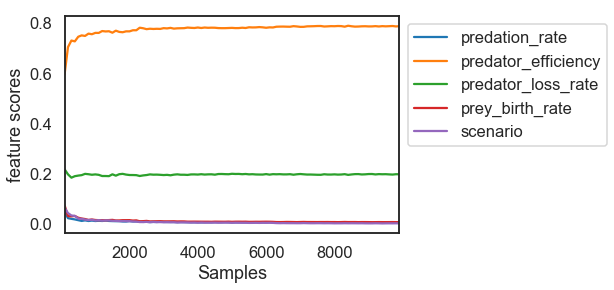

In [57]:
fig, ax = plt.subplots(1)

combined_scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()